# BabelNet biding Python <-> Java

This notebook shows how we can extract information from BabelNet to improve our knowledge graph.
BabelNet is heavily inspired on WordNet, and structured alike so that multiple lexemes may correspond to the same synset.

First, we are going to build and import a bridge between BabelNet and Python. This is required due to a limitation in PyJnius method overloading management.

In [1]:
import os
import jnius_config

prefix =  "/root/colla-framework/notebooks/3rdparty/lucene-index"
scala_path = "/usr/local/spark-3.0.0-bin-hadoop3.2/jars/scala-library-2.12.10.jar"
# BabelNet bridge
local_tools = "/root/colla-framework/notebooks/tools/BabelNet/target/scala-2.12/babelnetbridge_2.12-0.1.jar"
jnius_config.set_classpath(prefix + "/babelnet-api-4.0.1.jar", prefix + "/lib/*", local_tools, scala_path )
print(jnius_config.get_classpath())
import jnius

['/root/colla-framework/notebooks/3rdparty/lucene-index/babelnet-api-4.0.1.jar', '/root/colla-framework/notebooks/3rdparty/lucene-index/lib/*', '/root/colla-framework/notebooks/tools/BabelNet/target/scala-2.12/babelnetbridge_2.12-0.1.jar', '/usr/local/spark-3.0.0-bin-hadoop3.2/jars/scala-library-2.12.10.jar', '/opt/conda/lib/python3.8/site-packages/jnius/src']


In [2]:
# Jeff, forgive me for I hath sinned
def jimport(path):
    """
    Wrap a jnius import. This adds a global variable
    This adds a global variable with the name of the class.
    
    >>> jimport("java.lang.Math")
    >>> Math.sqrt(100)
    10.0
    
    As pyjnius does not seem to import static fields or subclasses
    automatically via an 'autoclass' invocation, one needs to
    import it manually:
    
    >>> jimport("org.mypackage.myclass")
    >>> jimport("org.mypackage.myclass$nestedclass")
    
    At the moment it is not allowed to import a nested class alone.
    """
    
    classname = path.split(".")[-1]
    if "$" in classname:
        parent_class, subclass = classname.split("$")
        exec("""
global ?parent_class
?parent_class.?subclass = jnius.autoclass(path)
""".replace("?parent_class", parent_class).replace("?subclass", subclass),
             globals(), {'path': path})
    else:
        exec("""
global ?classname
?classname = jnius.autoclass(path)
    """.replace("?classname", classname), globals(), {'path': path})

In [3]:
jimport("it.uniroma1.lcl.babelnet.BabelNet")
jimport("it.uniroma1.lcl.babelnet.BabelNetQuery")
jimport("it.uniroma1.lcl.babelnet.BabelNetQuery$Builder")
jimport("it.uniroma1.lcl.babelnet.BabelSynset")
jimport("it.uniroma1.lcl.jlt.util.Language")
jimport("com.babelscape.util.UniversalPOS")
jimport("tools.BabelNetBridge")
jimport("tools.BabelNetLexeme")

In [4]:
# Sanity check
for result in BabelNetBridge.getSynsetsForLexeme("home", "noun"):
    print(result.id().getID())

JavaException: JVM exception occurred: java.lang.NullPointerException

In [5]:
import os

from pyspark import SparkContext
from pyspark.sql import SparkSession

parquet_pos = os.path.join(os.getcwd(), "data/wiktionary/parquet-index_2.11-0.4.1-SNAPSHOT.jar")

spark = SparkSession.builder \
                        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
                        .config("spark.jars", parquet_pos) \
                        .getOrCreate()

spark.sparkContext.addPyFile(parquet_pos)

Now we extract the WDPG wordlist, extract the forms and save them in a local parquet for future uses

In [28]:
from tools.providers import WiktionaryProjectGutenberg, scrape_wiktionary_wordlists
from tools.extractors import extract_df, extract_form
from tools.dumps import get_filename_path

wdpg_list = WiktionaryProjectGutenberg.get_wordlist()

wiktionary_v2_df = spark.read.json("data/wiktionary/senses_examples_quotations_v2.json")
wdpg_df = spark.createDataFrame([[word] for word in wdpg_list], ['word'])
wiktionary_2_wdpg_unformed = wiktionary_v2_df.join(wdpg_df, "word", "inner")
wiktionary_2_wdpg_formed = extract_form(extract_df(wiktionary_2_wdpg_unformed))
wiktionary_2_wdpg_formed.write.mode("overwrite").parquet(get_filename_path("wiktionary/wiktionary_wdpg.parquet"))

#wiktionary_2_wdpg = spark.read.parquet("data/wiktionary/wiktionary_wdpg.parquet")

In [31]:
wiktionary_2_wdpg_formed.count()

19256

In [32]:
%autoreload 2

from tools.rdf_dumping import ExtractorGraph
graph = ExtractorGraph()

for row in wiktionary_2_wdpg_formed.rdd.toLocalIterator():
    if(row['head']['template_name'] != 'head'):
        graph.add_wiktionary(row)

graph.rdflib_graph.serialize(get_filename_path("output/wdpg_10000_common.ttl"), "turtle")

pos phrase for word limp not recognized, this entry will be ignored
pos phrase for word explicit not recognized, this entry will be ignored
pos phrase for word yon not recognized, this entry will be ignored


In [34]:
from tools.rdf_dumping import bn, rdf_type, kgl, kgl_prop
from tools.strings import strip_prefix
import re
# Match a sense, in the form of kgl:entity-Sx
matcher = re.compile("^(.*)-S\d+")
# for simplicity, a sense only has one gloss
sense_names = []
sense_glosses = []

for (sense, _, sense_description) in graph.g.triples((None, kgl_prop['definition'], None)):
    if not matcher.match(sense):
        continue
    if sense_description.language == "en":
        sense_names.append(sense.toPython())
        sense_glosses.append(sense_description.toPython())

In [35]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [36]:
# S-BERT is slow - especially on 10,000 senses
import numpy as np

sense_embeddings_path = "data/wiktionary/senses_encoded.npy"
if os.path.exists(sense_embeddings_path):
    sense_embeddings = np.load(sense_embeddings_path)
else:
    sense_embeddings = model.encode(sense_glosses)
    np.save(sense_embeddings_path, sense_embeddings)

In [37]:
sense_gloss_dict = dict(zip(sense_names, zip(sense_glosses, sense_embeddings)))

## Small distribution

In [46]:
wordlist_100 = spark.createDataFrame([[word] for word in WiktionaryProjectGutenberg.get_wordlist()[:100]], ["word"])
wordlist_df = wiktionary_v2_df.join(wordlist_100, "word", "inner")

In [51]:
excluded_pos = {"prep", "postp", "abbrev", "phrase", "article", "name", "conj", "symbol", "particle", "letter"}

In [52]:
from collections import defaultdict

freq_counter = defaultdict(int)
counted = set()

for entry in wordlist_df.rdd.toLocalIterator():
    word = entry.word
    pos = entry.pos
    
    if pos in excluded_pos:
        continue
        
    if (word, pos) in counted:
        continue
        
    counted.add((word, pos))
    
    try:
        print(f"Adding {word}-{pos}")
        for synset in BabelNetBridge.getSynsetsForLexeme(word, pos):
            for edge in synset.relatedWords():
                freq_counter[edge.getPointer().toString()]+=1
    finally:
        pass
print(freq_counter)

Adding some-pron
Adding some-det
Adding some-adv
Adding did-verb
Adding two-num
Adding two-noun
Adding us-pron
Adding us-det
Adding us-noun
Adding could-verb
Adding could-noun
Adding him-pron
Adding him-noun
Adding men-noun
Adding down-adv
Adding down-adj
Adding down-verb
Adding down-noun
Adding who-pron
Adding who-noun
Adding not-adv
Adding not-intj
Adding not-noun
Adding will-verb
Adding will-noun
Adding by-adv
Adding by-adj
Adding by-noun
Adding by-intj
Adding must-verb
Adding must-noun
Adding you-pron
Adding you-det
Adding you-verb
Adding more-det
Adding more-adv
Adding more-pron
Adding more-noun
Adding more-verb
Adding man-noun
Adding man-adj
Adding man-intj
Adding man-verb
Adding there-adv
Adding there-intj
Adding there-noun
Adding there-pron
Adding there-det
Adding can-verb
Adding can-noun
Adding was-verb
Adding their-det
Adding their-adv
Adding one-num
Adding one-pron
Adding one-noun
Adding one-adj
Adding one-verb
Adding in-verb
Adding in-adv
Adding in-noun
Adding in-adj
Adding

<BarContainer object of 25 artists>

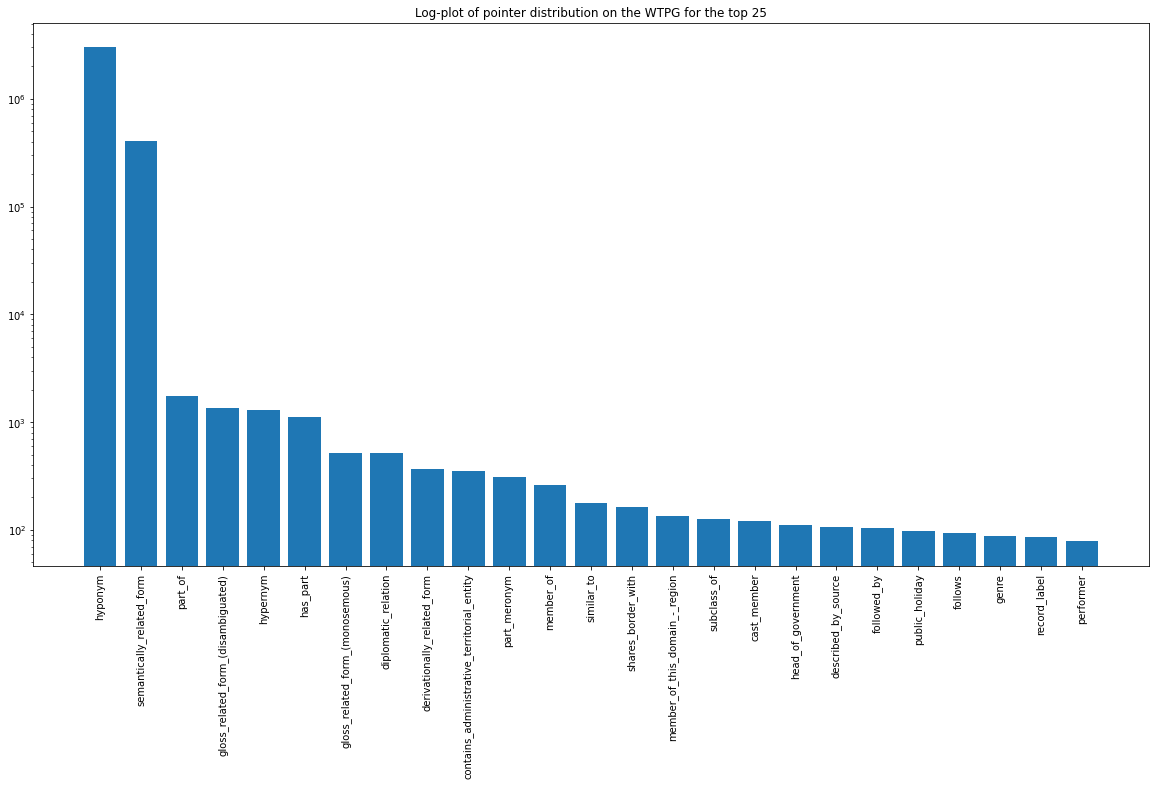

In [54]:
import matplotlib.pyplot as plt

threshold = 25
filtered = sorted(freq_counter.items(), key=lambda x: x[1])[-threshold:][::-1]

keys = [x[0] for x in filtered]
values = [x[1] for x in filtered]

fig = plt.figure(figsize=(20, 10))
plt.xticks(range(len(keys)), keys, rotation='vertical')

plt.title(f"Log-plot of pointer distribution on the WTPG for the top {threshold}")
plt.bar(keys, values, log=True)

In [98]:
jimport("it.uniroma1.lcl.babelnet.data.BabelPointer")

In [141]:
from tools.rdf_dumping import rdf_type, kgl, kgl_prop
from tools.strings import strip_prefix
related_to = {}
form_matcher = re.compile("^(.*)-F\d+")

def handle_pointer(lexeme, synset, edges, save_to_kg=False):
    BP = BabelPointer
    pointer_filter = [BP.HYPONYM, BP.HYPERNYM, BP.ALSO_SEE, 
                         BP.SEMANTICALLY_RELATED, BP.DERIVATIONALLY_RELATED,
                         BP.GLOSS_MONOSEMOUS, BP.SIMILAR_TO,
                         BP.ANTONYM, BP.VERB_GROUP]
    
    syntactic_pointers = [BP.DERIVATIONALLY_RELATED]
    
    edges = [p for p in edges if p.getPointer() in pointer_filter]
    
    for edge in edges:
        pointer = edge.getPointer()
        endpoint = edge.getBabelSynsetIDTarget()
        endpoint_prefixed = bn[endpoint.getID()[2:]]
        synset_id = bn[synset.id.getID()[2:]]
    
        # If the pointer is a semantic pointer, then one should only
        # keep the links between synsets
        if pointer not in syntactic_pointers:
            print(synset_id)
            print(endpoint_prefixed)
            if save_to_kg:
                graph.rdflib_graph.add(synset_id, kgl_prop[pointer.getShortName()], endpoint_prefixed)
            
        else:            
            endpoint_synset = BabelSynset(endpoint)
            endpoint_lemma = endpoint_synset.getMainSense().get().getFullLemma()
            endpoint_pos = endpoint_synset.getPOS()
            destination_entity = kgl[graph.hash(endpoint_lemma, endpoint_pos.toString().lower())]
            if save_to_kg:
                graph.rdflib_graph.add(lexeme, kgl_prop[pointer.getShortName()], destination_entity )
        
seen = set()

def query_babelnet(lexeme, word: str, pos: str, save_to_kg=False):
    pos = strip_prefix("http://grill-lab.org/kg/entity/", pos)
    if pos in excluded_pos:
        return
    
    if (word, pos) in seen:
        return
    
    #seen.add((word, pos))
    
    synsets = BabelNetBridge.getSynsetsForLexeme(word, pos)
    if len(synsets) == 0:
        return
    
    senses = [triple[2] for triple in graph.g.triples((lexeme, kgl_prop['sense'], None))]
    
    print(f"For word {word} ({pos})")

    pertaining_senses = [sense_gloss_dict[sense.toPython()] for sense in senses]
    print([gloss for gloss, embed in pertaining_senses])
    wiktionary_senses_embed = np.array([embed for gloss, embed in pertaining_senses])
    
    for synset in synsets:
        
        babelnet_id = synset.id().getID()
        res_synsets = synset.synsets()
        if len(res_synsets):
            glosses = res_synsets[0].getGloss()
        related = synset.relatedWords()
        
        # sources = [source.toString() for source in BabelNet.getInstance().getSynset(synset.id()).getSenseSources()]
        # print(sources)

        print(f"Determining embeddings for {babelnet_id} ({word})")
        glosses_embedded = np.array(model.encode([glosses]))
        glosses_embedded /= np.linalg.norm(glosses_embedded)
        
        # print(wiktionary_senses_embed.shape)
        # print(np.linalg.norm(wiktionary_senses_embed, axis=1).shape)
        wiktionary_senses_embed /= np.linalg.norm(wiktionary_senses_embed, axis=1)[:, np.newaxis]
        
        #print(glosses_embedded.shape)
        #print(wiktionary_senses_embed.T.shape)
        cosine_similarity = glosses_embedded.flatten() @ wiktionary_senses_embed.T
        
        # print(cosine_similarity)
        
        best_match = np.argmax(cosine_similarity)
        print(f"Given this BabelNet entry: {glosses}")
        print(f"And this Wiktionary gloss: {pertaining_senses[best_match][0]}")
        print(f"Best match score: {cosine_similarity[best_match]}")
        # TODO estimate ROC curve here
        if cosine_similarity[best_match] < 0.53:
            print("Not related to any existing sense. Creating a new sense.")
            if save_to_kg:
                sense_id = graph.add_sense(graph.hash(word, pos), lexeme, glosses)
        else:
            print("Related")
            sense_id = senses[best_match]
        if save_to_kg:
            graph.rdflib_graph.add((sense_id, kgl_prop['synset'], bn[babelnet_id]))
            graph.rdflib_graph.add((lexeme, kgl_prop['synset'], bn[babelnet_id]))
        
        handle_pointer(lexeme, synset, related)
        
        print("=" * 80)
        

for idx, (lexeme, _, word) in enumerate(graph.g.triples((None, kgl_prop["label"], None))):
    if form_matcher.match(lexeme):
        continue
    all_pos = [t[2] for t in graph.g.triples((lexeme, kgl_prop["pos"], None))]
    print(word, lexeme, all_pos)
    for pos in all_pos:
        query_babelnet(lexeme, word.toPython(), pos)
    if idx >= 500:
        break